In [78]:
import numpy as np
import os
from matplotlib import pyplot as plt
import random

colors = {
  'r': np.array([255,   0,   0], dtype=np.uint8),
  'o': np.array([255, 128,   0], dtype=np.uint8),
  'y': np.array([255, 255,   0], dtype=np.uint8),
  'g': np.array([0,   255,   0], dtype=np.uint8),
  'b': np.array([0,   128, 255], dtype=np.uint8),
  'i': np.array([0,     0, 255], dtype=np.uint8),
  'v': np.array([128,   0, 255], dtype=np.uint8)
}

imglen = 4
imgshape = (imglen, imglen, 3)
topleft_corner = (0,0)
topright_corner = (0,imglen-1)
botleft_corner = (imglen-1,0)
botright_corner = (imglen-1,imglen-1)

midpoint = (imglen//2, imglen//2)

# column divisions to get quadrants and columns 
topleft_col1 = [(0,0),(1,0)]
topleft_col2 = [(0,1),(1,1)]
topright_col1 = [(0,2),(1,2)]
topright_col2 = [(0,3),(1,3)]
botleft_col1 = [(2,0),(3,0)]
botleft_col2 = [(2,1),(3,1)]
botright_col1 = [(2,2),(3,2)]
botright_col2 = [(2,3),(3,3)]

# # more interactive way to get column divisions to get quadrants and columns 
# column_divisions = [ [] for _ in range(imglen * 2) ]
# for r in range(imglen):
#     for c in range(imglen):
#         if r < imglen//2:
#             column_divisions[c].append((r,c))
#         else:
#             column_divisions[c+imglen].append((r,c))

def random_color(exclude = []):
    # color choices for the grid 
    color_choices = ['r','g','b','v']
    if len(exclude) > 0:
        for color in colors:
            if np.array_equal(colors[color], exclude):
                color_choices.remove(color)
    return colors[np.random.choice(color_choices)]

def Bern(p):
    return np.random.rand() < p

def change_image(image, skip_pixels, skip_color):
    for row_idx in range(image.shape[0]):
        for col_idx in range(image.shape[1]):
            index = (row_idx, col_idx)
            if index not in skip_pixels:
                # if there are pixels with color outside the designated pixels 
                if (np.array_equal(image[index], skip_color)):
                    image[index] = random_color(exclude = skip_color)

def ensure_class_0_rules_apply(img):
    skip_pixels = []
    if Bern(0.5):
        color = img[topleft_corner]
        img[topright_corner] = color
        skip_pixels.extend([topleft_corner, topright_corner])
        if Bern(0.5):
            img[botleft_corner] = color
            skip_pixels.append(botleft_corner)
        else:
            img[botright_corner] = color
            skip_pixels.append(botright_corner)
    else:
        color = img[botleft_corner]
        img[botright_corner] = color
        skip_pixels.extend([botleft_corner, botright_corner])
        if Bern(0.5):
            img[topright_corner] = color
            skip_pixels.append(topright_corner)
        else:
            img[topleft_corner] = color
            skip_pixels.append(topleft_corner)
    
    # make sure the other pixels don't have the color in the 3 corners
    change_image(img, skip_pixels, color)
    
    # if image has 3 same corners & middle 2 same columns (label 0 and 2)
    if check_class_2(img) > 0:
        color_choices = ['r','g','b','v']
        midcolor = img[midpoint]
        for color_name in colors:
            if np.array_equal(colors[color_name], color):
                color_choices.remove(color_name)
            elif np.array_equal(colors[color_name], midcolor):
                color_choices.remove(color_name)
        random.shuffle(color_choices)
        img[midpoint] = colors[color_choices[0]]
    return img
                                
def ensure_class_1_rules_apply(img, percentages):
    p = np.random.rand()
    if p < percentages[0]:
        color = img[botleft_corner]
        skip_pixels = botleft_col1 + botleft_col2 + topright_col1 + topright_col2
    elif p < percentages[1]:
        color = img[topleft_corner]
        skip_pixels = topleft_col1 + topleft_col2 + topright_col1 + topright_col2
    elif p < percentages[2]:
        color = img[topright_corner]
        skip_pixels = topright_col1 + topright_col2 + botright_col1 + botright_col2
    elif p < percentages[3]:
        color = img[topleft_corner]
        skip_pixels = topleft_col1 + topleft_col2 + botright_col1 + botright_col2
    elif p < percentages[4]:
        color = img[topleft_corner]
        skip_pixels = topleft_col1 + topleft_col2 + botleft_col1 + botleft_col2
    else: 
        color = img[botleft_corner]
        skip_pixels = botleft_col1 + botleft_col2 + botright_col1 + botright_col2
        
    for pixel in skip_pixels:
        img[pixel] = color
    change_image(img, skip_pixels, color)
    return img 
    
def ensure_class_2_rules_apply(img, percentages):
    p = np.random.rand()
    class_0_confused = False
    if p < percentages[0]:
        color = img[topleft_corner]
        skip_pixels = topleft_col1 + topright_col2 + botleft_col1 + botright_col2
    elif p < percentages[1]:
        color = img[topleft_corner]
        skip_pixels = topleft_col1 + topright_col1 + botleft_col1 + botright_col1
    elif p < percentages[2]:
        color = img[topleft_corner]
        skip_pixels = topleft_col1 + topleft_col2 + botleft_col1 + botleft_col2
    elif p < percentages[3]:
        color = img[(0,1)]
        skip_pixels = topleft_col2 + topright_col1 + botleft_col2 + botright_col1
        # additional check that 3 corners are not same color
        class_0_confused = True
    elif p < percentages[4]:
        color = img[topright_corner]
        skip_pixels = topright_col1 + topright_col2 + botright_col1 + botright_col2
    else: 
        color = img[topright_corner]
        skip_pixels = topleft_col2 + topright_col2 + botleft_col2 + botright_col2
        
    for pixel in skip_pixels:
        img[pixel] = color
    change_image(img, skip_pixels, color)
    
    # for image with middle two columns, the 3 corners can have same color 
    if class_0_confused:
        color_choices = ['r','g','b','v']
        for color_name in colors:
            if np.array_equal(colors[color_name], color):
                color_choices.remove(color_name)
        random.shuffle(color_choices)
        img[topleft_corner] = colors[color_choices[0]]
        img[botleft_corner] = colors[color_choices[1]]
        img[botright_corner] = colors[color_choices[2]]
        img[topright_corner] = colors[color_choices[np.random.randint(0, 3)]]
    return img

# center square is same color 
def center_square_same_color(img):
    # Define the actions as a list of functions or lambda expressions
    midpoint = imglen//2
    center_color = img[(midpoint, midpoint)]
    skip_pixels = [(midpoint, midpoint), (midpoint-1, midpoint-1), (midpoint-1, midpoint), (midpoint, midpoint-1)]
    for pixel in skip_pixels:
        img[pixel] = center_color
        
    img = change_image(img, skip_pixels, center_color)
    return img


def generate_image(label, percentages):
    image = np.array([[random_color()
                      for _ in range(imglen)]
                        for __ in range(imglen)], dtype=np.uint8)

    if label == 0:
        return ensure_class_0_rules_apply(image)
        # return center_square_same_color(image)
    elif label == 1:
        return ensure_class_1_rules_apply(image, percentages)
    else:
        return ensure_class_2_rules_apply(image, percentages)

In [79]:
def check_circle(img):
    midpoint = imglen//2
    center_color = img[(midpoint, midpoint)]
    skip_pixels = [(midpoint, midpoint), (midpoint-1, midpoint-1), (midpoint-1, midpoint), (midpoint, midpoint-1)]
    for r in range(len(img)):
        for c in range(len(img[r])):
            index = (r,c)
            if index in skip_pixels:
                if np.array_equal(img[index], center_color):
                    return 1 
                else:
                    return -1 
            else:
                if np.array_equal(img[index], center_color):
                    return -1
                else:
                    return 1
                
def check_class_0(img):
    label = -1
    color = img[topleft_corner]
    if (np.array_equal(img[botleft_corner],color)) and (np.array_equal(img[topright_corner], color)):
        label = 0
    elif (np.array_equal(img[botright_corner],color)) and (np.array_equal(img[topright_corner], color)):
        label = 1
    elif (np.array_equal(img[botleft_corner], color)) and (np.array_equal(img[botright_corner], color)):
        label = 3
    
    color = img[topright_corner]
    if (np.array_equal(img[botleft_corner], color)) and (np.array_equal(img[botright_corner], color)):
        if (np.array_equal(img[topleft_corner], color)):
            label = 10
        else:
            label = 2
    return label 

def check_individual_class(image, color, label_pixels):
    for pixel in label_pixels:
        if not np.array_equal(image[pixel], color):
            return False 
    return True

def check_class_1(img):
    label0_pixels = botleft_col1 + botleft_col2 + topright_col1 + topright_col2
    label1_pixels = topleft_col1 + topleft_col2 + topright_col1 + topright_col2
    label2_pixels = topright_col1 + topright_col2 + botright_col1 + botright_col2
    label3_pixels = topleft_col1 + topleft_col2 + botright_col1 + botright_col2
    label4_pixels = topleft_col1 + topleft_col2 + botleft_col1 + botleft_col2
    label5_pixels = botleft_col1 + botleft_col2 + botright_col1 + botright_col2
    
    if check_individual_class(img, img[botleft_corner], label0_pixels):
        return 0
    elif check_individual_class(img, img[topleft_corner], label1_pixels):
        return 1
    elif check_individual_class(img, img[topright_corner], label2_pixels):
        return 2
    elif check_individual_class(img, img[topleft_corner], label3_pixels):
        return 3
    elif check_individual_class(img, img[topleft_corner], label4_pixels):
        return 4
    elif check_individual_class(img, img[botleft_corner], label5_pixels):
        return 5
    else:
        return -1 
    
def check_class_2(img):
    label0_pixels = topleft_col1 + topright_col2 + botleft_col1 + botright_col2
    label1_pixels = topleft_col1 + topright_col1 + botleft_col1 + botright_col1
    label2_pixels = topleft_col1 + topleft_col2 + botleft_col1 + botleft_col2
    label3_pixels = topleft_col2 + topright_col1 + botleft_col2 + botright_col1
    label4_pixels = topright_col1 + topright_col2 + botright_col1 + botright_col2
    label5_pixels = topleft_col2 + topright_col2 + botleft_col2 + botright_col2
    
    if check_individual_class(img, img[topleft_corner], label0_pixels):
        return 0
    elif check_individual_class(img, img[topleft_corner], label1_pixels):
        return 1
    elif check_individual_class(img, img[topleft_corner], label2_pixels):
        return 2
    elif check_individual_class(img, img[(0,1)], label3_pixels):
        return 3
    elif check_individual_class(img, img[topright_corner], label4_pixels):
        return 4
    elif check_individual_class(img, img[topright_corner], label5_pixels):
        return 5
    else:
        return -1 

In [80]:
train_y = ([0] * 1500) + ([1] * 1500) + ([2] * 1500)
test_y = ([0] * 500) + ([1] * 500) + ([2] * 500)
random.shuffle(train_y)
random.shuffle(test_y)

train_y = np.array(train_y).astype(np.uint8)
test_y = np.array(test_y).astype(np.uint8)

test_percentages = {0: 0.17, 1: 0.34, 2:0.51, 3:0.68, 4:0.85}  
train_percentages = {0: 0.17, 1: 0.34, 2:0.51, 3:0.68, 4:0.85}
# train_percentages = {0: 0.21, 1: 0.42, 2: 0.5, 3:0.71, 4:0.79}  
# train_percentages = {0: 0.225, 1: 0.45, 2: 0.5, 3:0.725, 4:0.775}
# train_percentages = {0: 0.25, 1: 0.5, 2: 0, 3:0.75, 4:0}  

data = (
  np.array([generate_image(y, train_percentages) for y in train_y]),
  np.array([generate_image(y, test_percentages) for y in test_y]), train_y, test_y)

In [81]:
train_x = data[0]
train_y = data[2]

class_0 = []
class_1 = 0
for i in range(train_x.shape[0]):
    # if center are the same color
    # if train_y[i] == 0 and check_circle(train_x[i]) < 0:
    #     class_0.append(i)
        
    # if 3 corners are the same color
    if check_class_0(train_x[i]) > 0:
        if check_class_1(train_x[i]) > 0 or check_class_2(train_x[i]) > 0:
            class_0.append(i)
            print (train_y[i])
    
    # if two quadrants are the same color 
    if check_class_1(train_x[i]) > 0:
        if check_class_2(train_x[i]) > 0:
            class_1 += 1
print (class_0)
print (class_1)

[]
978


In [82]:
train_x = data[0]
train_y = data[2]

count = {0: {0:0, 1:0, 2:0, 3:0}, 1: {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}, 2:{0:0, 1:0, 2:0, 3:0, 4:0, 5:0}}

class_0 = 0
class_1 = 0
class_2 = 0
for i in range(train_x.shape[0]):
    if train_y[i] == 0:
        count[0][check_class_0(train_x[i])] += 1
        class_0 += 1
    if train_y[i] == 1:
        count[1][check_class_1(train_x[i])] += 1
        class_1 += 1
    if train_y[i] == 2:
        count[2][check_class_2(train_x[i])] += 1
        class_2 += 1
        
print (class_0)
print (class_1)
print (class_2)
count

1500
1500
1500


{0: {0: 339, 1: 399, 2: 386, 3: 376},
 1: {0: 253, 1: 255, 2: 246, 3: 266, 4: 253, 5: 227},
 2: {0: 256, 1: 257, 2: 228, 3: 293, 4: 251, 5: 215}}

In [84]:
test_x = data[1]
test_y = data[3]

count = {0: {0:0, 1:0, 2:0, 3:0}, 1: {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}, 2:{0:0, 1:0, 2:0, 3:0, 4:0, 5:0}}
class_0 = 0
class_1 = 0
class_2 = 0
for i in range(test_x.shape[0]):
    if test_y[i] == 0:
        count[0][check_class_0(test_x[i])] += 1
        class_0 += 1
    if test_y[i] == 1:
        count[1][check_class_1(test_x[i])] += 1
        class_1 += 1
    if test_y[i] == 2:
        count[2][check_class_2(test_x[i])] += 1
        class_2 += 1
        
print (class_0)
print (class_1)
print (class_2)
count

500
500
500


{0: {0: 128, 1: 115, 2: 116, 3: 141},
 1: {0: 75, 1: 94, 2: 81, 3: 93, 4: 77, 5: 80},
 2: {0: 100, 1: 78, 2: 95, 3: 87, 4: 63, 5: 77}}

In [83]:
test_x = data[1]
test_y = data[3]

class_0 = 0
class_1 = 0
class_2 = 0
for i in range(test_x.shape[0]):
    # if 3 corners are the same color
    if check_class_0(test_x[i]) > 0:
        if check_class_1(test_x[i]) > 0 or check_class_2(test_x[i]) > 0:
            class_0 += 1
            
    if check_class_1(test_x[i]) > 0:
        if check_class_2(test_x[i]) > 0:
            class_1 += 1
            if check_class_0(test_x[i]) > 0:
                class_2 += 1
print (class_0)
print (class_1)
print (class_2)

0
316
0


In [85]:
from torch.utils.data import Dataset, DataLoader

class PixelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, ind):
        x = self.X[ind].ravel() / 255.0
        y = self.y[ind]
        return x, y

train_set = PixelDataset(train_x, train_y)
test_set  = PixelDataset(test_x, test_y)

batch_size = 24
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

In [86]:
def test(model, test_loader):
    model.eval()

    total = 0
    correct = 0
    for images, labels in test_loader:
        images = images.to(device).float()
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(images)
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    print ('Accuracy: ' + str(correct / total))

In [87]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Linear(4 * 4 * 3, 20),
    nn.ReLU(),
    nn.Linear(20, 3)
).to(device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

epochs = 200

for epoch in range(epochs):
    model.train()
    losses = []
    correct = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device).float()
        labels = labels.to(device)

        output = model(images)
        pred = torch.max(output.data, 1)[1]
        correct += (labels == pred).sum().item()
        
        loss = criterion(output, labels)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

    if epoch % 10 == 0:
        print('Epoch %d | Loss %6.2f | Accuracy %.2f' % (epoch, sum(losses)/len(losses), correct / len(train_loader.dataset)))
        test(model, test_loader)

Epoch 0 | Loss   1.08 | Accuracy 0.43
Accuracy: 0.5853333333333334
Epoch 10 | Loss   0.33 | Accuracy 0.86
Accuracy: 0.8473333333333334
Epoch 20 | Loss   0.28 | Accuracy 0.87
Accuracy: 0.854
Epoch 30 | Loss   0.26 | Accuracy 0.88
Accuracy: 0.8626666666666667
Epoch 40 | Loss   0.25 | Accuracy 0.89
Accuracy: 0.8593333333333333
Epoch 50 | Loss   0.24 | Accuracy 0.89
Accuracy: 0.8653333333333333
Epoch 60 | Loss   0.23 | Accuracy 0.89
Accuracy: 0.858
Epoch 70 | Loss   0.22 | Accuracy 0.90
Accuracy: 0.856
Epoch 80 | Loss   0.22 | Accuracy 0.90
Accuracy: 0.856
Epoch 90 | Loss   0.21 | Accuracy 0.90
Accuracy: 0.8526666666666667
Epoch 100 | Loss   0.20 | Accuracy 0.90
Accuracy: 0.854
Epoch 110 | Loss   0.20 | Accuracy 0.91
Accuracy: 0.854
Epoch 120 | Loss   0.20 | Accuracy 0.91
Accuracy: 0.8526666666666667
Epoch 130 | Loss   0.19 | Accuracy 0.91
Accuracy: 0.8493333333333334
Epoch 140 | Loss   0.19 | Accuracy 0.91
Accuracy: 0.858
Epoch 150 | Loss   0.19 | Accuracy 0.91
Accuracy: 0.853333333333333

In [88]:
# Compute model outputs on test instances
labels = []
outputs = []

for i, (image, label) in enumerate(test_loader):
    with torch.no_grad():
        images = image.to(device).float()
    labels.extend(label.numpy())

    # Compute model inferences
    output = model(images)
    output = torch.nn.functional.softmax(output, dim=1).squeeze(0).detach().cpu().numpy()
    outputs.append(output)
    
outputs = np.vstack(outputs)

In [89]:
incorrect = {0: {1: 0, 2: 0}, 1: {0: 0, 2: 0}, 2: {0: 0, 1: 0}}

predictions = [np.argmax(output) for output in outputs]
for i in range(len(predictions)):
    label = labels[i]
    prediction = predictions[i]
    if (label != prediction):
        incorrect[label][prediction] += 1
incorrect

{0: {1: 20, 2: 19}, 1: {0: 9, 2: 77}, 2: {0: 15, 1: 93}}

In [90]:
# Print model performance statistics
predictions = [np.argmax(output) for output in outputs]
correctness = [label == predictions[i] for i, label in enumerate(labels)]
correct_inds = [i for i, label in enumerate(labels) if label == predictions[i]]
incorrect_inds = [i for i, label in enumerate(labels) if label != predictions[i]]
print(f'MODEL STATS:')
print(f'Accuracy: {len(correct_inds) / len(labels):.2%}')
print(f'Mean prediction confidence: {np.mean([np.max(output) for output in outputs]):.2f}')
print(f'Mean prediction confidence (correct): {np.mean([np.max(outputs[i]) for i in correct_inds]):.2f}')
print(f'Mean prediction confidence (incorrect): {np.mean([np.max(outputs[i]) for i in correct_inds]):.2f}')

MODEL STATS:
Accuracy: 84.47%
Mean prediction confidence: 0.91
Mean prediction confidence (correct): 0.95
Mean prediction confidence (incorrect): 0.95


In [91]:
from treelib import Tree
def make_tree(misaligned = False):
    tree = Tree()

    # Add root
    tree.create_node(tag='root', identifier='root', parent=None, data=None)

    # Add superclass nodes
    tree.create_node(tag='f1', identifier='f1', parent='root', data=None)
    tree.create_node(tag='f2', identifier='f2', parent='root', data=None)

    # Add class nodes
    tree.create_node(tag='f1a', 
                     identifier='f1a', 
                     parent='f1', 
                     data=None)
    if misaligned:
        tree.create_node(tag='f2a', 
                         identifier='f2a', 
                         parent='f1', 
                         data=None)
    else: 
        tree.create_node(tag='f2a', 
                         identifier='f2a', 
                         parent='f2', 
                         data=None)
    tree.create_node(tag='f2b', 
                     identifier='f2b', 
                     parent='f2', 
                     data=None)
    return tree
tree = make_tree()
print(f'Tree with {tree.size()} nodes across {tree.depth() + 1} levels.')

Tree with 6 nodes across 3 levels.


In [106]:
def show(tree, hide_zeros=False):
    string = tree.show(stdout=False)
    for node_id, node in tree.nodes.items():
        node_value = node.data
        if node_value is not None:
            node_value = round(node_value, 2)
            if node_value == 0 and hide_zeros:
                node_value = ''
            else:
                node_value = f'{node_value:.2f}'
        string = string.replace(f'{node_id}\n', f'{node_id} ({node_value})\n')
    return string
print (show(tree))

root (1.00)
├── f1 (1.00)
│   ├── f1a (1.00)
│   └── f2a (0.00)
└── f2 (0.00)
    └── f2b (0.00)



In [93]:
def propagate(outputs, tree):
    """Propagate model outputs through the tree."""
    # Assign values to the leaves of the tree
    for i, value in enumerate(outputs):
        if i == 0:
            name = 'f1a'
        elif i == 1:
            name = 'f2a'
        elif i == 2:
            name = 'f2b'
        else:
            name = ''
        node = tree.get_node(name)
        node.data = value
        
    # Propagate values up the tree
    level = tree.depth() - 1 # leaf level = depth
    while level >= 0:
        nodes = tree.filter_nodes(lambda x: tree.depth(x) == level)
        for node in nodes:
            reachable_leaves = tree.leaves(node.identifier)
            node.data = np.sum([leaf.data for leaf in reachable_leaves])
        level -= 1
    
    return tree

In [94]:
# Measure abstraction alignment by propagating model outputs through the hierarchy
aligned_trees = []
for i in range(len(labels)):
    # print (outputs[i])
    tree = propagate(outputs[i], make_tree())
    aligned_trees.append(tree)

In [95]:
# Compute class and superclass accuracy and entropy
from scipy import stats
# Confidence vectors, correctness, and entropy for the class and superclass levels for every instance
class_confidences = []
class_correctness = []
class_entropy = []
superclass_confidences = []
superclass_correctness = []
superclass_entropy = []

CLASS_LABELS = ['f1a', 'f2a', 'f2b']
SUPERCLASS_LABELS = ['f1', 'f2']
CLASS_TO_SUPERCLASS = {0: 0, 1: 1, 2: 1}

for i, tree in enumerate(aligned_trees):
    class_confidence = [tree.get_node(c).data for c in CLASS_LABELS]
    class_confidences.append(class_confidence)
    assert np.argmax(class_confidence) == predictions[i]
    class_correctness.append(np.argmax(class_confidence) == labels[i])
    class_entropy.append(stats.entropy(class_confidence))    
    superclass_confidence = [tree.get_node(s).data for s in SUPERCLASS_LABELS]
    superclass_confidences.append(superclass_confidence)
    superclass_correctness.append(np.argmax(superclass_confidence) == CLASS_TO_SUPERCLASS[labels[i]])
    superclass_entropy.append(stats.entropy(superclass_confidence))
class_confidences = np.array(class_confidences)
class_correctness = np.array(class_correctness)
class_entropy = np.array(class_entropy)
superclass_confidences = np.array(superclass_confidences)
superclass_correctness = np.array(superclass_correctness)
superclass_entropy = np.array(superclass_entropy)

print('CONFIDENCE, CORRECTNESS, AND ENTROPY FOR EVERY INSTANCE AT THE CLASS AND SUPERCLASS LEVEL')
print(f'Class confidence {class_confidences.shape}; all sum to one: {np.all([np.isclose(np.sum(c), 1.0) for c in class_confidences])}')
print(f'Class correctness {class_correctness.shape}; equal to accuracy: {np.sum(class_correctness)/len(class_correctness):.2%}')
print(f'Class entropy {class_entropy.shape}')
print(f'Superclass confidence {superclass_confidences.shape}; all sum to one: {np.all([np.isclose(np.sum(c), 1.0) for c in superclass_confidences])}')
print(f'Superclass correctness {superclass_correctness.shape}; superclass accuracy: {np.sum(superclass_correctness)/len(superclass_correctness):.2%}')
print(f'Superclass entropy {superclass_entropy.shape}')

print(f'ACCURACY -- class-level: {np.sum(class_correctness)/len(class_correctness):.2%}; superclass-level: {np.sum(superclass_correctness)/len(superclass_correctness):.2%}')
print(f'ENTROPY --- class-level: {np.mean(class_entropy):.2f}; superclass-level: {np.mean(superclass_entropy):.2f}')

CONFIDENCE, CORRECTNESS, AND ENTROPY FOR EVERY INSTANCE AT THE CLASS AND SUPERCLASS LEVEL
Class confidence (1500, 3); all sum to one: True
Class correctness (1500,); equal to accuracy: 84.47%
Class entropy (1500,)
Superclass confidence (1500, 2); all sum to one: True
Superclass correctness (1500,); superclass accuracy: 95.93%
Superclass entropy (1500,)
ACCURACY -- class-level: 84.47%; superclass-level: 95.93%
ENTROPY --- class-level: 0.20; superclass-level: 0.06


In [96]:
misaligned_tree = make_tree(misaligned=True)
print(f'Tree with {misaligned_tree.size()} nodes across {misaligned_tree.depth() + 1} levels.')
print (show(misaligned_tree))

Tree with 6 nodes across 3 levels.
root (None)
├── f1 (None)
│   ├── f1a (None)
│   └── f2a (None)
└── f2 (None)
    └── f2b (None)



In [97]:
# Measure abstraction alignment by propagating model outputs through the hierarchy
misaligned_trees = []
for i in range(len(labels)):
    tree = propagate(outputs[i], make_tree(misaligned=True))
    misaligned_trees.append(tree)

In [107]:
# Compute class and superclass accuracy and entropy
from scipy import stats
# Confidence vectors, correctness, and entropy for the class and superclass levels for every instance
class_confidences = []
class_correctness = []
class_entropy = []
superclass_confidences = []
superclass_correctness = []
superclass_entropy = []

CLASS_LABELS = ['f1a', 'f2a', 'f2b']
SUPERCLASS_LABELS = ['f1', 'f2']
CLASS_TO_SUPERCLASS = {0: 0, 1: 0, 2: 1}

low_entropy = []

for i, tree in enumerate(misaligned_trees):
    class_confidence = [tree.get_node(c).data for c in CLASS_LABELS]
    class_confidences.append(class_confidence)
    assert np.argmax(class_confidence) == predictions[i]
    class_correctness.append(np.argmax(class_confidence) == labels[i])
    class_entropy.append(stats.entropy(class_confidence))
    
    superclass_confidence = [tree.get_node(s).data for s in SUPERCLASS_LABELS]
    superclass_confidences.append(superclass_confidence)
    superclass_correctness.append(np.argmax(superclass_confidence) == CLASS_TO_SUPERCLASS[labels[i]])
    superclass_entropy.append(stats.entropy(superclass_confidence))
    if (stats.entropy(superclass_confidence)) < 0.6:
        low_entropy.append(i)
        
class_confidences = np.array(class_confidences)
class_correctness = np.array(class_correctness)
class_entropy = np.array(class_entropy)
superclass_confidences = np.array(superclass_confidences)
superclass_correctness = np.array(superclass_correctness)
superclass_entropy = np.array(superclass_entropy)

print('CONFIDENCE, CORRECTNESS, AND ENTROPY FOR EVERY INSTANCE AT THE CLASS AND SUPERCLASS LEVEL')
print(f'Class confidence {class_confidences.shape}; all sum to one: {np.all([np.isclose(np.sum(c), 1.0) for c in class_confidences])}')
print(f'Class correctness {class_correctness.shape}; equal to accuracy: {np.sum(class_correctness)/len(class_correctness):.2%}')
print(f'Class entropy {class_entropy.shape}')
print(f'Superclass confidence {superclass_confidences.shape}; all sum to one: {np.all([np.isclose(np.sum(c), 1.0) for c in superclass_confidences])}')
print(f'Superclass correctness {superclass_correctness.shape}; superclass accuracy: {np.sum(superclass_correctness)/len(superclass_correctness):.2%}')
print(f'Superclass entropy {superclass_entropy.shape}')

print(f'ACCURACY -- class-level: {np.sum(class_correctness)/len(class_correctness):.2%}; superclass-level: {np.sum(superclass_correctness)/len(superclass_correctness):.2%}')
print(f'ENTROPY --- class-level: {np.mean(class_entropy):.2f}; superclass-level: {np.mean(superclass_entropy):.2f}')

CONFIDENCE, CORRECTNESS, AND ENTROPY FOR EVERY INSTANCE AT THE CLASS AND SUPERCLASS LEVEL
Class confidence (1500, 3); all sum to one: True
Class correctness (1500,); equal to accuracy: 84.47%
Class entropy (1500,)
Superclass confidence (1500, 2); all sum to one: True
Superclass correctness (1500,); superclass accuracy: 86.60%
Superclass entropy (1500,)
ACCURACY -- class-level: 84.47%; superclass-level: 86.60%
ENTROPY --- class-level: 0.20; superclass-level: 0.16


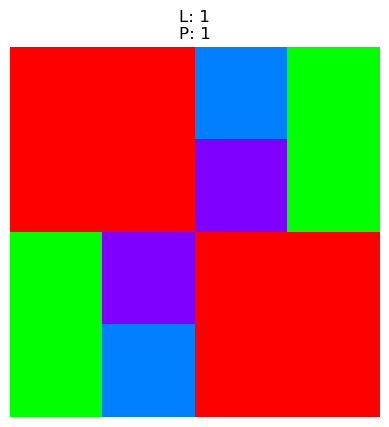

TOP PREDICTED CLASSES:  ['1 (0.90)', '2 (0.10)', '0 (0.00)']
PROPAGATED TREE:
root (1.00)
├── f1 (0.00)
│   └── f1a (0.00)
└── f2 (1.00)
    ├── f2a (0.90)
    └── f2b (0.10)

[7.444848e-06, 0.8950606, 0.10493199]
class entropy: 0.33588094
superclass confidence: [7.444848e-06, 0.9999926]
superclass entropy: 9.529963e-05


In [112]:
# An example hierarchy propagation
index = 2

image = test_set[index][0]
image = np.reshape(image, (4, 4, 3)) * 255
# plt.imshow(image)
plt.imshow(image.astype(int))
plt.axis('off')
plt.title(f'L: {labels[index]}\nP: {predictions[index]}')
plt.show()

top_predictions = np.argsort(outputs[index])[-3:]
print('TOP PREDICTED CLASSES: ', [f'{i} ({outputs[index][i]:.2f})' for i in top_predictions][::-1])

print('PROPAGATED TREE:')
print(show(aligned_trees[index]))

tree = aligned_trees[index]
class_confidence = [tree.get_node(c).data for c in CLASS_LABELS]
print (class_confidence)
print ('class entropy: ' + str(stats.entropy(class_confidence))) 
superclass_confidence = [tree.get_node(s).data for s in SUPERCLASS_LABELS]
print ('superclass confidence: ' + str(superclass_confidence))
print ('superclass entropy: ' + str(stats.entropy(superclass_confidence)))

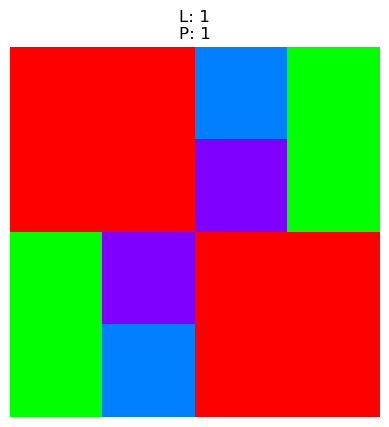

TOP PREDICTED CLASSES:  ['1 (0.90)', '2 (0.10)', '0 (0.00)']
PROPAGATED TREE:
root (1.00)
├── f1 (0.90)
│   ├── f1a (0.00)
│   └── f2a (0.90)
└── f2 (0.10)
    └── f2b (0.10)

class entropy: 0.33588094
[0.89506805, 0.10493199]
superclass entropy: 0.3357864


In [111]:
# An example hierarchy propagation
index = 2

image = test_set[index][0]
image = np.reshape(image, (4, 4, 3)) * 255
# plt.imshow(image)
plt.imshow(image.astype(int))
plt.axis('off')
plt.title(f'L: {labels[index]}\nP: {predictions[index]}')
plt.show()

top_predictions = np.argsort(outputs[index])[-3:]
print('TOP PREDICTED CLASSES: ', [f'{i} ({outputs[index][i]:.2f})' for i in top_predictions][::-1])

print('PROPAGATED TREE:')
print(show(misaligned_trees[index]))

tree = misaligned_trees[index]
class_confidence = [tree.get_node(c).data for c in CLASS_LABELS]
# print (class_confidence)
print ('class entropy: ' + str(stats.entropy(class_confidence))) 
superclass_confidence = [tree.get_node(s).data for s in SUPERCLASS_LABELS]
print (superclass_confidence)
print ('superclass entropy: ' + str(stats.entropy(superclass_confidence)))